# Análise Exploratória de SRAG 2019
Este notebook realiza uma análise exploratória inicial dos dados agregados de Síndrome Respiratória Aguda Grave (SRAG)
para o ano de 2019, cruzando informações com estimativas populacionais de 2021. O objetivo é fornecer uma visão
geral da distribuição de casos por estado e ao longo do tempo, calcular medidas de incidência per capita e explorar
correlações simples com a população de cada unidade federativa.

Os dados utilizados foram previamente extraídos e disponibilizados no repositório:
- **aggregated_sivep_2019.csv**: contagem de casos de SRAG hospitalizados por estado e data de início dos sintomas.
- **estimativa_dou_2021.xls**: estimativas populacionais oficiais para 2021 por Unidade da Federação.

A análise inclui estatísticas descritivas, gráficos e combinações entre as bases para mostrar tendências e comparações.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configurações básicas
pd.set_option('display.max_columns', None)
%matplotlib inline

## Carregamento dos dados SRAG 2019
O conjunto `aggregated_sivep_2019.csv` contém os campos:

- `SG_UF`: sigla da unidade federativa.
- `DT_SIN_PRI`: data de início dos sintomas.
- `COUNT`: número de casos registrados para essa combinação de UF e data.

Vamos carregar esse arquivo e preparar algumas colunas para análise.

In [2]:
# Caminho do arquivo no ambiente local
sivep_path = '/home/oai/share/aggregated_sivep_2019.csv'
df_sivep = pd.read_csv(sivep_path)
# Converter a coluna de datas para datetime
df_sivep['DT_SIN_PRI'] = pd.to_datetime(df_sivep['DT_SIN_PRI'], errors='coerce')
# Exibir as primeiras linhas
df_sivep.head()

,SG_UF,DT_SIN_PRI,COUNT
0,AC,2018-12-30,3
1,AC,2019-01-01,2
2,AC,2019-01-03,1
3,AC,2019-01-04,1
4,AC,2019-01-06,1


## Estatísticas descritivas
Vamos calcular estatísticas simples, como a soma total de casos por estado ao longo do ano e descrever
a distribuição temporal dos casos.

In [3]:
# Total de casos por estado
cases_by_state = df_sivep.groupby('SG_UF')['COUNT'].sum().sort_values(ascending=False)
cases_by_state_df = cases_by_state.reset_index().rename(columns={'COUNT': 'TOTAL_CASES'})
cases_by_state_df.head()

,SG_UF,TOTAL_CASES
0,SP,12338
1,PR,6805
2,MG,4035
3,RS,3588
4,PE,2614


### Total de casos por estado
O gráfico abaixo mostra os 10 estados com maior número total de casos de SRAG em 2019.

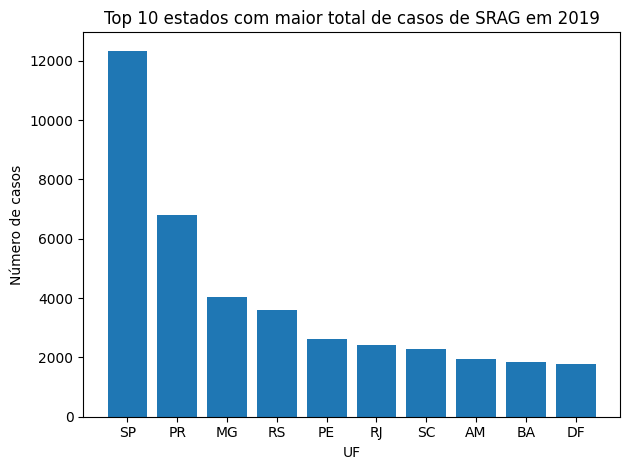

In [4]:
# Plotar barras dos top 10 estados
top_states = cases_by_state_df.head(10)
plt.figure()
plt.bar(top_states['SG_UF'], top_states['TOTAL_CASES'])
plt.title('Top 10 estados com maior total de casos de SRAG em 2019')
plt.xlabel('UF')
plt.ylabel('Número de casos')
plt.tight_layout()
plt.show()

### Série temporal de casos totais
A seguir, agregamos o número de casos por data em todo o país para observar a evolução ao longo do tempo.

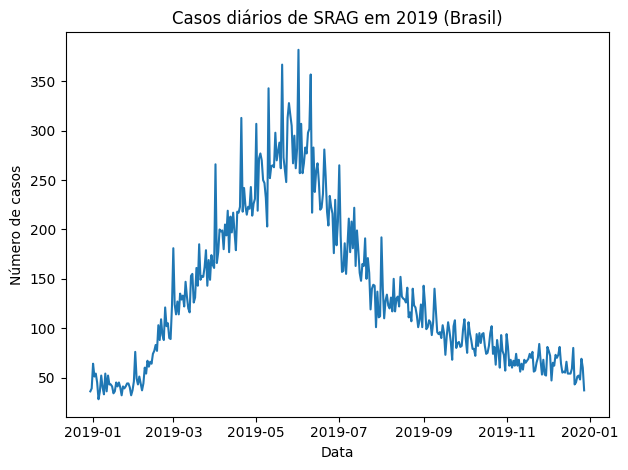

In [5]:
# Agregar número de casos por data
cases_by_date = df_sivep.groupby('DT_SIN_PRI')['COUNT'].sum().sort_index()
plt.figure()
plt.plot(cases_by_date.index, cases_by_date.values)
plt.title('Casos diários de SRAG em 2019 (Brasil)')
plt.xlabel('Data')
plt.ylabel('Número de casos')
plt.tight_layout()
plt.show()

## População estimada em 2021
Utilizamos o arquivo `estimativa_dou_2021.xls` para obter a população de cada unidade federativa em 2021.
A população de 2021 é usada como aproximação para calcular a incidência (casos por 100 mil habitantes) para 2019.

In [6]:
# Carregar estimativa populacional
pop_path = '/home/oai/share/estimativa_dou_2021.xls'
# Ler a aba com Brasil e UFs, ignorando as duas primeiras linhas de cabeçalho
pop_df = pd.read_excel(pop_path, sheet_name='BRASIL E UFs', skiprows=2, header=None, names=['Entity', 'drop', 'Population'])
# Remover linhas sem população
pop_df = pop_df.dropna(subset=['Population'])
# Criar mapa de nome da UF para sigla
name_to_code = {
    'Rondônia':'RO', 'Acre':'AC', 'Amazonas':'AM', 'Roraima':'RR', 'Pará':'PA', 'Amapá':'AP', 'Tocantins':'TO',
    'Maranhão':'MA','Piauí':'PI','Ceará':'CE','Rio Grande do Norte':'RN','Paraíba':'PB','Pernambuco':'PE','Alagoas':'AL','Sergipe':'SE','Bahia':'BA',
    'Minas Gerais':'MG','Espírito Santo':'ES','Rio de Janeiro':'RJ','São Paulo':'SP',
    'Paraná':'PR','Santa Catarina':'SC','Rio Grande do Sul':'RS',
    'Mato Grosso do Sul':'MS','Mato Grosso':'MT','Goiás':'GO','Distrito Federal':'DF'
}
# Filtrar apenas estados presentes no dicionário
pop_df_states = pop_df[pop_df['Entity'].isin(name_to_code.keys())].copy()
# Mapear para siglas
pop_df_states['SG_UF'] = pop_df_states['Entity'].map(name_to_code)
# Limpar e converter a coluna de população: remover qualquer caractere não numérico e converter para int
pop_df_states['Population'] = pop_df_states['Population'].astype(str).str.replace(r'[^0-9]', '', regex=True).astype(int)
pop_df_states.head()

,Entity,drop,Population,SG_UF
2,Rondônia,NaN,1815278,RO
3,Acre,NaN,906876,AC
4,Amazonas,NaN,4269995,AM
5,Roraima,NaN,652713,RR
6,Pará,NaN,8777124,PA


## Incidência de SRAG por 100 mil habitantes
Ao combinar o total de casos por estado com sua população, podemos calcular a incidência (casos por 100 mil habitantes).

In [7]:
# Combinar total de casos e população
cases_pop = cases_by_state_df.merge(pop_df_states[['SG_UF','Population']], on='SG_UF', how='left')
# Calcular incidência por 100 mil habitantes
cases_pop['Incidencia_100k'] = cases_pop['TOTAL_CASES'] / cases_pop['Population'] * 100000
# Ordenar por incidência
cases_pop_sorted = cases_pop.sort_values('Incidencia_100k', ascending=False)
cases_pop_sorted.head()

,SG_UF,TOTAL_CASES,Population,Incidencia_100k
10,MS,1750,2839188,61.637341
1,PR,6805,11597484,58.676520
7,AM,1951,4269995,45.690920
17,AC,349,906876,38.483762
3,RS,3588,11466630,31.290798


### Incidência por estado
Gráfico de barras mostrando as incidências por 100 mil habitantes dos 10 estados com maior valor.

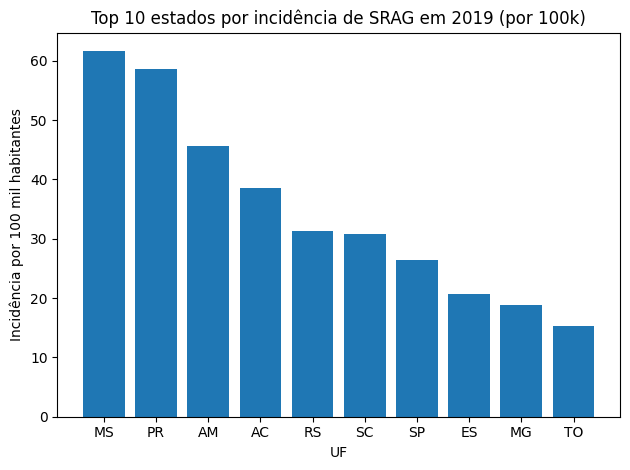

In [8]:
# Top 10 por incidência
top_incidence = cases_pop_sorted.head(10)
plt.figure()
plt.bar(top_incidence['SG_UF'], top_incidence['Incidencia_100k'])
plt.title('Top 10 estados por incidência de SRAG em 2019 (por 100k)')
plt.xlabel('UF')
plt.ylabel('Incidência por 100 mil habitantes')
plt.tight_layout()
plt.show()

### Relação entre população e número de casos
Este gráfico de dispersão permite observar se há correlação simples entre a população absoluta de uma UF e o total de casos de SRAG registrados.

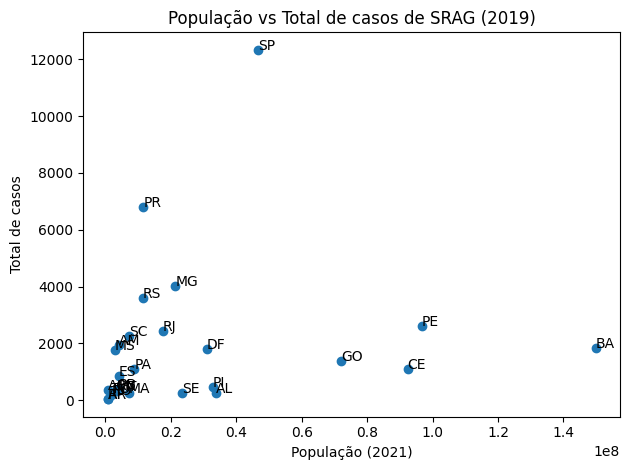

In [9]:
plt.figure()
plt.scatter(cases_pop['Population'], cases_pop['TOTAL_CASES'])
plt.title('População vs Total de casos de SRAG (2019)')
plt.xlabel('População (2021)')
plt.ylabel('Total de casos')
# Adicionar rótulos dos estados
for idx, row in cases_pop.iterrows():
    plt.annotate(row['SG_UF'], (row['Population'], row['TOTAL_CASES']))
plt.tight_layout()
plt.show()

## Conclusões
- Os estados com maiores números absolutos de casos em 2019 pertencem majoritariamente às regiões Sudeste e Sul,
  refletindo em parte o tamanho populacional dessas UFs.
- Ao calcular a incidência por 100 mil habitantes, observa-se que alguns estados do Norte e Centro-Oeste apresentam taxas
  comparativamente elevadas, sugerindo proporção de casos maior em relação à população.
- A correlação visual entre população e número de casos indica tendência positiva (mais população tende a mais casos),
  mas a incidência per capita ajuda a revelar estados onde a carga de casos foi relativamente maior.

Estas análises são apenas um ponto de partida para investigações mais profundas, incluindo avaliações de tendências sazonais,
exploração de outros anos (como 2020) e integração com dados ambientais, socioeconômicos e demográficos adicionais.